<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [ ]:
# upload file
from google.colab import files 
uploaded = files.upload()

Saving Run01.csv to Run01.csv


In [ ]:
# read in file
import pandas as pd 
import io 
df = pd.read_csv(io.BytesIO(uploaded['Run01.csv'])) 
print(df)

       Time (s)  Pressure (bar)  ...  Caliper Temperature (degC)  Torque (Nm)
0          0.00            0.01  ...                       45.96          0.0
1          0.05            0.01  ...                       45.96          0.0
2          0.10            0.01  ...                       45.96          0.0
3          0.15            0.01  ...                       45.96          0.0
4          0.20            0.01  ...                       45.96          0.0
...         ...             ...  ...                         ...          ...
9997     499.85            0.01  ...                       50.45          0.0
9998     499.90            0.01  ...                       50.45          0.0
9999     499.95            0.01  ...                       50.45          0.0
10000    500.00            0.01  ...                       50.45          0.0
10001    500.05            0.01  ...                       50.45          0.0

[10002 rows x 8 columns]


In [ ]:
time = df['Time (s)'].to_numpy()
series = df['Torque (Nm)'].to_numpy()

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# split time identified through visual inspection of the torque signal
split_time = 4500
end_time = 7000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:end_time]
x_valid = series[split_time:end_time]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
x_train.shape

(4500,)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


AttributeError: ignored

In [ ]:
l1 = tf.keras.layers.LSTM(256, input_shape = [window_size]
l2 = tf.keras.layers.Dense(256) #, input_shape=[window_size])
l3 = tf.keras.layers.Dropout(0.2)
lo = tf.keras.layers.Dense(1) #, input_shape=[window_size])
model = tf.keras.models.Sequential([l1, l2, l3, lo])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

#print("Layer weights {}".format(l0.get_weights()))

Epoch 1/100
140/140 [==============================] - 1s 4ms/step - loss: 6262.5186
Epoch 2/100
140/140 [==============================] - 1s 4ms/step - loss: 2339.9031
Epoch 3/100
140/140 [==============================] - 1s 4ms/step - loss: 1987.5270
Epoch 4/100
140/140 [==============================] - 1s 4ms/step - loss: 1675.6869
Epoch 5/100
140/140 [==============================] - 1s 4ms/step - loss: 1298.5200
Epoch 6/100
140/140 [==============================] - 1s 4ms/step - loss: 1463.6439
Epoch 7/100
140/140 [==============================] - 1s 4ms/step - loss: 1342.5176
Epoch 8/100
140/140 [==============================] - 1s 4ms/step - loss: 1143.5637
Epoch 9/100
140/140 [==============================] - 1s 4ms/step - loss: 1154.3367
Epoch 10/100
140/140 [==============================] - 1s 4ms/step - loss: 1184.1777
Epoch 11/100
140/140 [==============================] - 1s 4ms/step - loss: 1130.0479
Epoch 12/100
140/140 [==============================] - 1s 4ms/

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

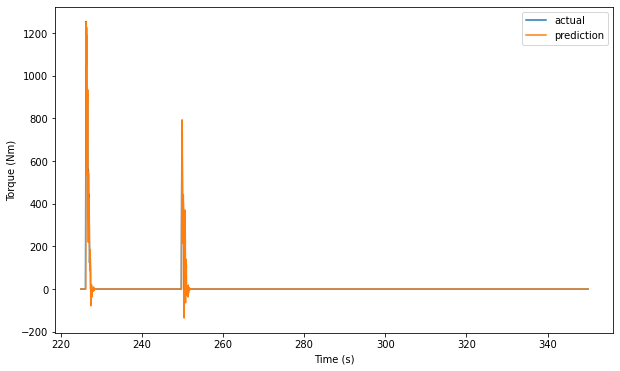

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.plot(time_valid, x_valid, label='actual')
ax.plot(time_valid, results[0:2500], label='prediction')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
ax.legend()
plt.show()


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results[0:2500]).numpy()

2.3166027

In [ ]:
tf.keras.metrics.mean_squared_error(x_valid, results[0:2500]).numpy()

461.37634